In [63]:
import numpy as np
import fnmatch
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import keras
from keras import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LeakyReLU
import keras.backend as kb
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import scikeras
from scikeras.wrappers import KerasClassifier, KerasRegressor
from joblib import Parallel, delayed
import joblib
from sklearn.metrics import accuracy_score

In [64]:
#For when working on Google Colab, mount the drive
#from google.colab import drive
#drive.mount('/content/drive')

In [65]:
#For when working on Google Colab, change to the appropriate directory
#os.chdir('drive/MyDrive/292B Final/')

#In all cases, get the current directory for file saving/loading
dir = os.getcwd()

In [67]:
#Function - get image data from folder and assign to variables
def getData(vers):

    #Folder of dataset
    direc=dir + '/Direction/Inputs/ImgProcessed/'+ vers + '/'

    #Initialize storage variables
    #Number of images in dataset
    n=len(fnmatch.filter(os.listdir(direc), '*.jpg'))

    #Processed image size
    pix=np.array(Image.open(direc+os.listdir(direc)[0])).shape[0]

    #Full set of images
    imgall=np.zeros([n,pix,pix])

    #One hot encoding
    num_classes = 6
    y=np.zeros([n,num_classes])

    #Classification type
    turntype = np.full([n, 1], "", dtype=object)

    #Image name
    imgname = np.full([n, 1], "", dtype=object)

    #Iterate over files in the directory
    for i, file in enumerate(sorted(os.listdir(direc))):

        #Get full file path                     
        filename = os.path.join(direc, file)
        #Double check to ensure it is a valid file
        if os.path.isfile(filename):

            #Store image data as array                 
            imgall[i,:,:]=np.array(Image.open(filename))

            #Store the type of turn
            turntype[i]=file.rsplit('_', 1)[0].replace('Conv_','')

            #Store the image name
            imgname[i]=file

            #One hot encoding, based on keyterms in filename
            if 'L_' in filename:
                if '3_' in filename:
                    if 'W_' in filename:
                        y[i]=[0,1,0,0,0,0]
                    else:
                        y[i]=[1,0,0,0,0,0]
                else:
                    y[i]=[0,0,1,0,0,0]
            else:
                if '3_' in filename:
                    if 'W_' in filename:
                        y[i]=[0,0,0,0,1,0]
                    else:
                        y[i]=[0,0,0,0,0,1]
                else:
                    y[i]=[0,0,0,1,0,0]

    #Convert to float32 and rescale/normalize the pixel values to be 0-1
    imgall=imgall.astype('float32')/255
    imgall=imgall.reshape(-1,pix,pix,1)

    return imgall,y,turntype,imgname,pix

In [68]:
#Get the default processed imageset used for model training
imgall,y,turntype,imgname,pix = getData('V1')

#Split the images, encodings, and file labels into training and test datasets
#imgtrain, imgtest, ytrain, ytest, turntypetrain, turntypetest, imgnametrain, imgnametest = train_test_split(imgall, y, turntype, imgname, test_size=0.2, stratify=y)

#Load the utilized data split from file, if necessary
imgtrain, imgtest, ytrain, ytest, turntypetrain, turntypetest, imgnametrain, imgnametest = joblib.load(dir + '/Direction/Inputs/train_test_distance.pkl')

In [69]:
#Function to build ML model
def build_clf(fnum1, fnum2, fnum3, fnum4, do, num_classes):
    #Build the model
    mod = Sequential()

    #Convolution and pooling 1
    mod.add(Conv2D(fnum1, kernel_size=(3, 3),activation=tf.keras.layers.LeakyReLU(alpha=0.1),input_shape=(pix,pix,1),padding='same'))
    mod.add(MaxPooling2D((2, 2),padding='same'))
    mod.add(Dropout(do))

    #Convolution and pooling 2
    mod.add(Conv2D(fnum2, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.1),padding='same'))
    mod.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
    mod.add(Dropout(do))

    #Convolution and pooling 3
    mod.add(Conv2D(fnum3, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.1),padding='same'))                 
    mod.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
    mod.add(Dropout(do))

    #Fully connected
    mod.add(Flatten())
    mod.add(Dense(fnum4, activation=tf.keras.layers.LeakyReLU(alpha=0.1)))
    mod.add(Dropout(do))
    mod.add(Dense(num_classes,activation='softmax'))

    #Compile the model
    mod.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])
    return mod

In [ ]:
#DON'T RUN THIS CELL UNLESS WANTING TO RE-OPTIMIZE (takes long time + GPU)
#Hyperparameter optimization:
#Make wrapper for Keras model in order to do scikit hyperparameter search
clf = KerasClassifier(model=build_clf, fnum1=16, fnum2=16, fnum3=16, fnum4=16, do=0)

#Set test values for model hyperparameters
params={'batch_size':[12, 25, 50],
        'epochs':[12],
        'fnum1':[16,32,64,128],
        'fnum2':[16,32,64,128],
        'fnum3':[16,32,64,128],
        'fnum4':[16,32,64,128],
        'do':[0,.1,.25],
        }

#Perform Randomized CV search:
#Run model with various assortments of hyperparameters and measure performance
rs = RandomizedSearchCV(estimator=clf, param_distributions = params, scoring='accuracy', n_iter = 100, cv=5, verbose=3, return_train_score=True)
rs_result = rs.fit(imgtrain, ytrain)

In [ ]:
#Get output from RandomizedCV search

#Save the results table
#df = pd.DataFrame(rs_result.cv_results_)
#df.to_csv('./Direction/SearchCV/RandomizedSearchCV_ResultsDirection.csv')

#Save the best parameters and estimator as a pickle files
#best_params = rs_result.best_params_
#best_model = rs_result.best_estimator_
#joblib.dump(best_params, dir + '/Direction/SearchCV/best_parameters_direction.pkl')
#joblib.dump(best_model, dir + '/Direction/SearchCV/best_estimator_direction.pkl')

#If re-loading later from external file:
best_params = joblib.load(dir + '/Direction/SearchCV/best_parameters_direction.pkl')
modelfinal = joblib.load(dir + '/Direction/SearchCV/best_estimator_direction.pkl')

In [10]:
#Refit again after CV search on whole training set (optional, but allows for training on whole training set)
#Set optimized best parameters
fnum1 = best_params['fnum1']
fnum2 = best_params['fnum2']
fnum3 = best_params['fnum3']
fnum4 = best_params['fnum4']
do = best_params['do']
batch = best_params['batch_size']

#Set up early stopping if performance improvement tapers 
es = keras.callbacks.EarlyStopping(
    monitor='loss',
    mode='min',
    min_delta = 1e-3,
    patience = 25,
    restore_best_weights = True,
    verbose=1)

#Build model with best parameters found in randomized search
batch_size = batch
epochs = 200
modelfinal=build_clf(fnum1=fnum1,fnum2=fnum2,fnum3=fnum3,fnum4=fnum4,do=do, num_classes=y.shape[1])

#Train model
trainfinal = modelfinal.fit(imgtrain,ytrain, batch_size=batch_size, epochs=epochs,callbacks=[es], verbose=1)

#Save the model for future use
joblib.dump(trainfinal, dir + '/Direction/ModelFit/trainfinal_direction.pkl')
joblib.dump(modelfinal, dir + '/Direction/ModelFit/modelfinal_direction.pkl')

#Output some performance metrics
loss_hist = trainfinal.history['loss']
best_epoch = np.argmin(trainfinal.history['loss']) + 1
print('Best epoch = ', best_epoch)
print('Smallest loss =', np.min(loss_hist))

Epoch 1/200
9/9 [==============================] - 3s 42ms/step - loss: 2.0979 - accuracy: 0.3300
Epoch 2/200
9/9 [==============================] - 0s 30ms/step - loss: 0.7223 - accuracy: 0.6800
Epoch 3/200
9/9 [==============================] - 0s 31ms/step - loss: 0.5274 - accuracy: 0.8800
Epoch 4/200
9/9 [==============================] - 0s 31ms/step - loss: 0.2509 - accuracy: 0.9200
Epoch 5/200
9/9 [==============================] - 0s 31ms/step - loss: 0.1018 - accuracy: 0.9700
Epoch 6/200
9/9 [==============================] - 0s 30ms/step - loss: 0.1488 - accuracy: 0.9500
Epoch 7/200
9/9 [==============================] - 0s 31ms/step - loss: 0.0979 - accuracy: 0.9600
Epoch 8/200
9/9 [==============================] - 0s 31ms/step - loss: 0.0700 - accuracy: 0.9800
Epoch 9/200
9/9 [==============================] - 0s 32ms/step - loss: 0.0209 - accuracy: 1.0000
Epoch 10/200
9/9 [==============================] - 0s 33ms/step - loss: 0.0060 - accuracy: 1.0000
Epoch 11/200
9/9 [=

INFO:tensorflow:Assets written to: C:\Users\jadoyle\AppData\Local\Temp\tmpe0x2ywnh\assets


INFO:tensorflow:Assets written to: C:\Users\jadoyle\AppData\Local\Temp\tmpe0x2ywnh\assets


INFO:tensorflow:Assets written to: C:\Users\jadoyle\AppData\Local\Temp\tmpo4g5cqe0\assets


INFO:tensorflow:Assets written to: C:\Users\jadoyle\AppData\Local\Temp\tmpo4g5cqe0\assets


Best epoch =  62
Smallest loss = 3.9902832213556394e-05


In [70]:
#Or load previously trained model
trainfinal = joblib.load(dir + '/Direction/ModelFit/trainfinal_direction.pkl')
modelfinal = joblib.load(dir + '/Direction/ModelFit/modelfinal_direction.pkl')

#Output some performance metrics
loss_hist = trainfinal.history['loss']
best_epoch = np.argmin(trainfinal.history['loss']) + 1
print('Best epoch = ', best_epoch)
print('Smallest loss =', np.min(loss_hist))

Best epoch =  62
Smallest loss = 3.9902832213556394e-05


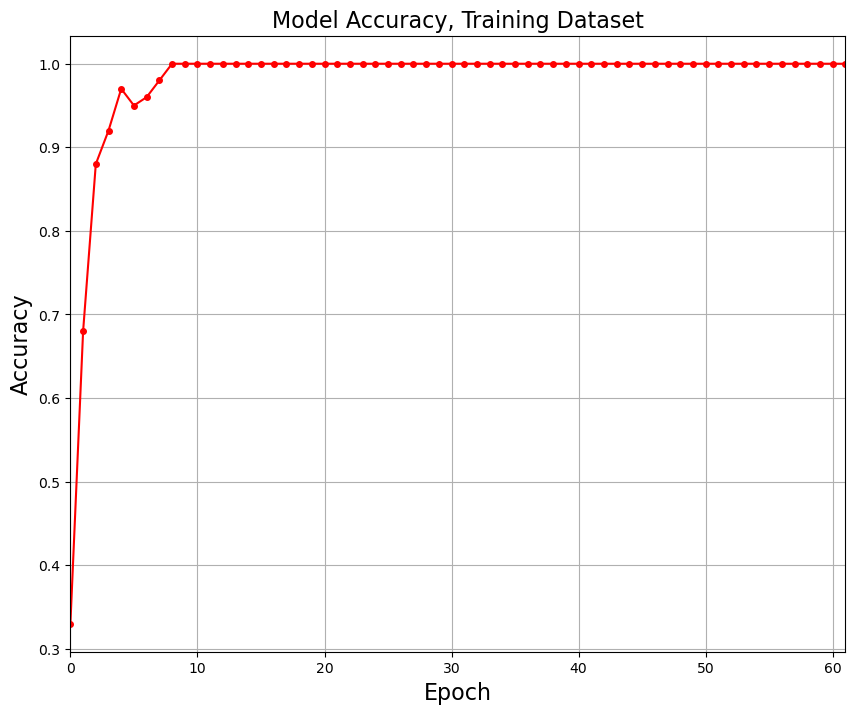

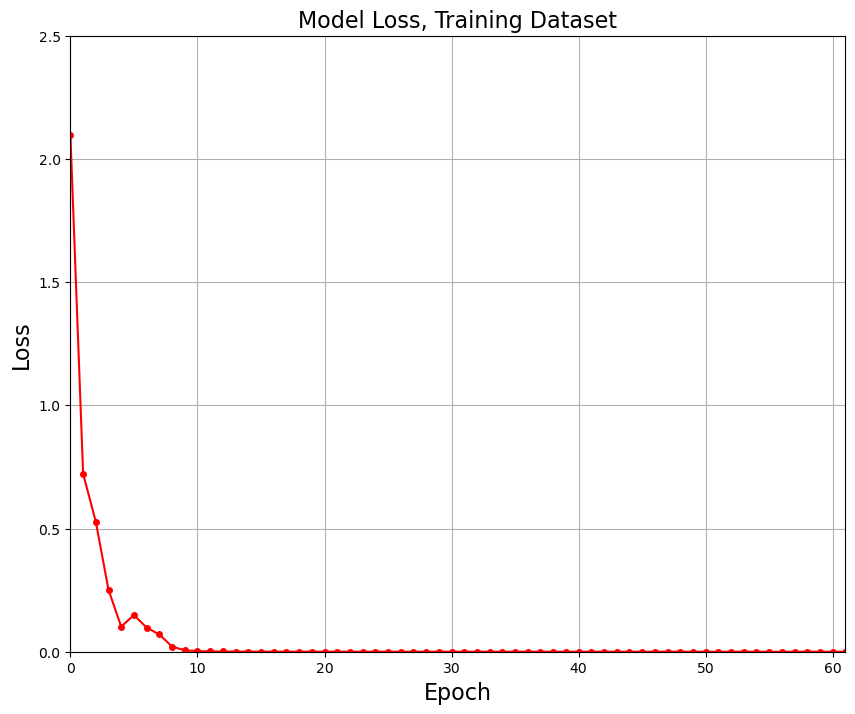

In [71]:
#Model performance outputs
train_accuracy = trainfinal.history['accuracy']

#Plot accuracy
plt.figure(figsize=(10,8))
plt.plot(range(len(train_accuracy)), train_accuracy, 'r', linewidth=1.5, marker ='.', markersize=8, label='Training Data')
plt.title('Model Accuracy, Training Dataset', fontsize=16)
plt.xlim(0,len(loss_hist)-1)
plt.xlabel('Epoch',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.grid()

#Plot loss
plt.figure(figsize=(10,8))
plt.plot(range(len(loss_hist)), loss_hist, 'r', linewidth=1.5, marker ='.', markersize=8, label='Training Data')
plt.title('Model Loss, Training Dataset', fontsize=16)
plt.xlim(0,len(loss_hist)-1)
plt.ylim(0,np.ceil(np.max(loss_hist)/.5)*.5)
plt.xlabel('Epoch',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.grid()

In [72]:
#Function to use model for prediction, output incorrect predictions
def modelPred(imgdata, y, turntype, imagename, dataset):
    
    #Predict the outcomes for the training and test data using the trained model
    y_pred=modelfinal.predict(imgdata)
    y_predclass=np.reshape(np.argmax(y_pred,axis=1),(y_pred.shape[0],1))
    y_predname = np.full([y_predclass.shape[0], 1], "", dtype=object)
    y_class = np.reshape(np.argmax(y,axis=1),(y.shape[0],1))
    
    #Output accuracy
    accuracy = accuracy_score(y_class, y_predclass)
    print('{} Accuracy:'.format(dataset), accuracy)
    
    for i in range(y_predclass.shape[0]):
        if y_predclass[i] == 0:
            y_predname[i] = 'L_3'
        elif y_predclass[i] == 1:
            y_predname[i] = 'L_W_3'
        elif y_predclass[i] == 2:
            y_predname[i] = 'L_50'
        elif y_predclass[i] == 3:
            y_predname[i] = 'R_50'
        elif y_predclass[i] == 4:
            y_predname[i] = 'R_W_3'
        elif y_predclass[i] == 5:
            y_predname[i] = 'R_3' 
            
    y_compare=np.hstack([y_predname,turntype,imagename])
    df = pd.DataFrame(y_compare, columns = ['Prediction','Actual','Image Number'])
    
    df_wrong=df
    df_wrong.drop(df[(df['Prediction'] == df['Actual'])].index, inplace = True)
    
    df.to_csv(dir + '/Direction/WrongPreds/{}_pred_wrong_Direction.csv'.format(dataset))
    
    return df_wrong

In [73]:
#Model performance
#Make predictions, show incorrect predictions
train_wrong = modelPred(imgtrain, ytrain, turntypetrain, imgnametrain, 'Train')     
test_wrong = modelPred(imgtest, ytest, turntypetest, imgnametest, 'Test')

#Display results in browser
display(train_wrong)
display(test_wrong)

4/4 [==============================] - 0s 121ms/step
Train Accuracy: 1.0
1/1 [==============================] - 0s 16ms/step
Test Accuracy: 0.9615384615384616


,Prediction,Actual,Image Number


,Prediction,Actual,Image Number
14,L_W_3,L_3,Conv_L_3_4.jpg


In [79]:
#Test other distorted image datasets on model to see how they perform

#Folder location within ./Images/ 
folder='V7'
dis_name = 'DistortedV7'

#Get the desired imageset
imgall_dis,y_dis,turntype_dis,imgname_dis,pix_dis = getData(folder)

#Calculate and show ranked error
dis_wrong = modelPred(imgall_dis, y_dis, turntype_dis, imgname_dis, dis_name)
display(dis_wrong)

4/4 [==============================] - 0s 90ms/step
DistortedV7 Accuracy: 0.5396825396825397


,Prediction,Actual,Image Number
0,L_W_3,L_3,Conv_L_3_1.jpg
3,L_50,L_3,Conv_L_3_12.jpg
5,R_W_3,L_3,Conv_L_3_14.jpg
6,L_50,L_3,Conv_L_3_15.jpg
7,L_50,L_3,Conv_L_3_16.jpg
9,R_W_3,L_3,Conv_L_3_18.jpg
14,R_W_3,L_3,Conv_L_3_22.jpg
15,L_50,L_3,Conv_L_3_23.jpg
17,L_W_3,L_3,Conv_L_3_4.jpg
20,L_50,L_3,Conv_L_3_7.jpg
